# Домашнее задание
Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов

## Цель:
В этом домашнем задании будем заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.


## Описание/Пошаговая инструкция выполнения домашнего задания:
### Подготовка:

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха).

3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html).

### Моделирование:
Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).

4. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.

5. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.

6. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.

7. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.

8. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.
Несколько советов:
- для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
- попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.

9. Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза.

## Теперь вы круто разбираетесь в прогнозировании и временных рядах :)

In [1]:
#импорты
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from pathlib import Path
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from fake_useragent import UserAgent

from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Решение

## 1. Скачиваю данные

Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [2]:
#file_link = 'https://archive.ics.uci.edu/static/public/492/metro+interstate+traffic+volume.zip'
#user = UserAgent().random
#response = requests.get(file_link, headers = {'User-Agent': user})
#print(response)

данные сохранились в папку 'data', файл "Metro_Interstate_Traffic_Volume.csv"

In [3]:
path_file = Path(r'./data/Metro_Interstate_Traffic_Volume.csv') #относительный путь

## 2. EDA. Подготовка данных

### 2.1. Проводим базовый EDA, вам понадобятся только 4 столбца датасета 
- traffic_volume (наша целевая переменная), 
- date_time, holiday (является ли день некоторым праздником), 
- temp (температура воздуха).

In [4]:
data = pd.read_csv(path_file)

In [5]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [6]:
feat_columns = ['date_time', 'holiday', 'temp']
targ_columns = ['traffic_volume']

In [7]:
data_columns = targ_columns + feat_columns
data_columns

['traffic_volume', 'date_time', 'holiday', 'temp']

In [8]:
df = data[data_columns].copy()

In [9]:
df.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [10]:
df['date_time'] = pd.to_datetime(df['date_time']) # преобразование столбца в тип datetime

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  48204 non-null  int64         
 1   date_time       48204 non-null  datetime64[ns]
 2   holiday         48204 non-null  object        
 3   temp            48204 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [12]:
# Проверка на пустые
df.isna().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

In [13]:
# Проверка на дубли
print(f"кол-во дублей по колонке {df['date_time'].name}: {df['date_time'].duplicated().sum()}")

кол-во дублей по колонке date_time: 7629


In [14]:
# Удаление дублей по колонке 'date_time'
duplicated_drop_index = df.loc[df['date_time'].duplicated()].index
df.drop(index = duplicated_drop_index, inplace = True)
print(f"кол-во дублей по колонке {df['date_time'].name}: {df['date_time'].duplicated().sum()}")

кол-во дублей по колонке date_time: 0


#### Графики и распредления

In [15]:
columns_view = 'traffic_volume'

In [16]:
df.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


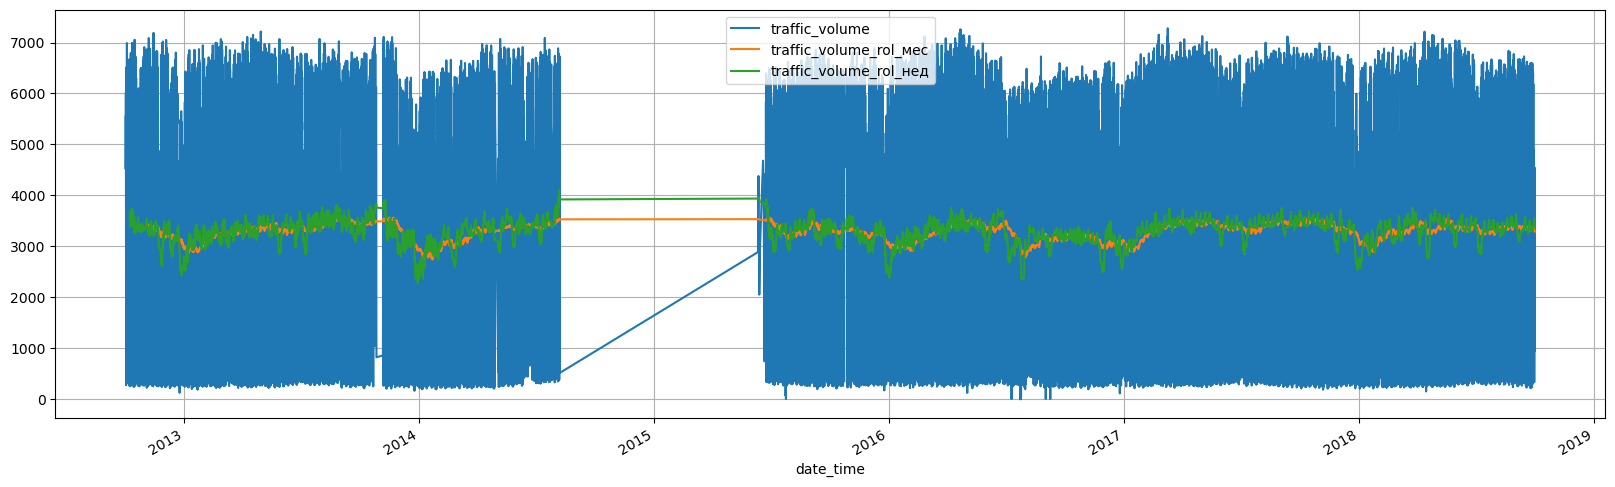

In [17]:
# График временного ряда y = 'traffic_volume'
df.set_index('date_time').plot(y = columns_view, figsize = (20,6))
df.set_index('date_time')['traffic_volume'].rolling(720).mean().plot(y = columns_view, 
                                                                     figsize = (20,6), 
                                                                     grid = True)
df.set_index('date_time')['traffic_volume'].rolling(144).mean().plot(y = columns_view, 
                                                                     figsize = (20,6), 
                                                                     grid = True)
plt.legend(['traffic_volume', 'traffic_volume_rol_мес', 'traffic_volume_rol_нед'])

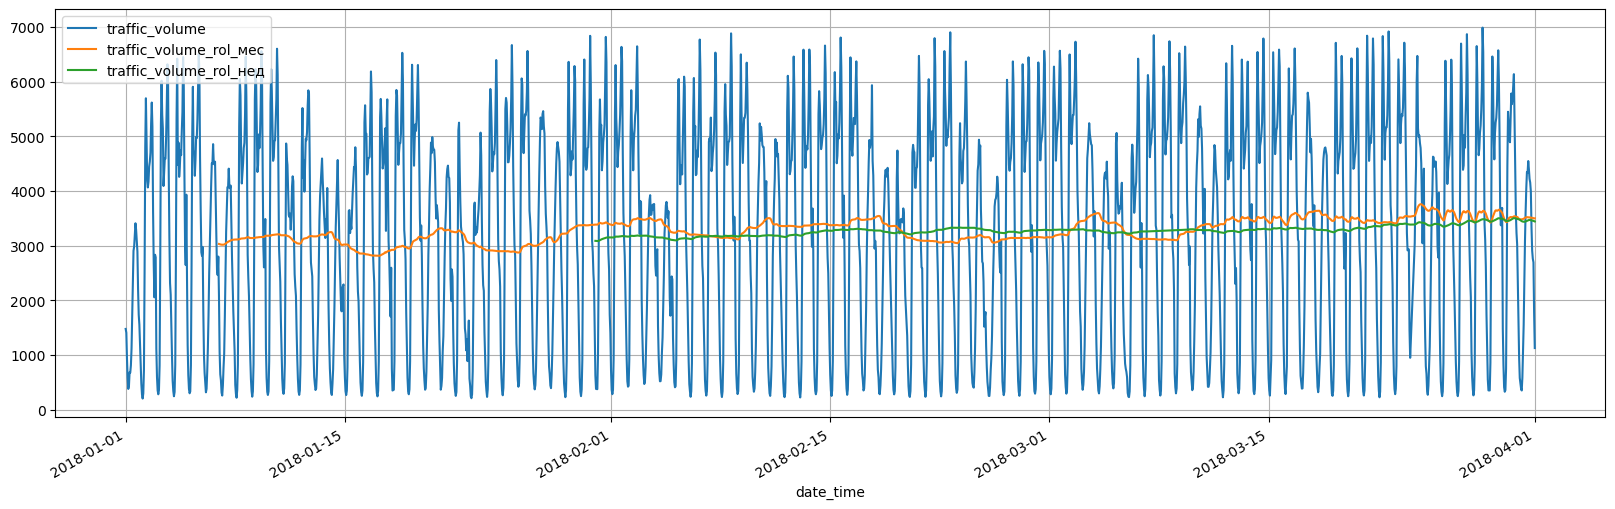

In [18]:
# График временного ряда y = 'traffic_volume'
rol_start = '2018-1-1 00:00:00'
rol_finish = '2018-4-1 00:00:00'  
df.set_index('date_time').loc[rol_start:rol_finish].plot(y = columns_view, figsize = (20,6), grid = True)
df.set_index('date_time').loc[rol_start:rol_finish]['traffic_volume'].rolling(144).mean().plot(y = columns_view, 
                                                                                               figsize = (20,6), 
                                                                                               grid = True)
df.set_index('date_time').loc[rol_start:rol_finish]['traffic_volume'].rolling(720).mean().plot(y = columns_view, 
                                                                                               figsize = (20,6), 
                                                                                               grid = True)
plt.legend(['traffic_volume', 'traffic_volume_rol_мес', 'traffic_volume_rol_нед'])

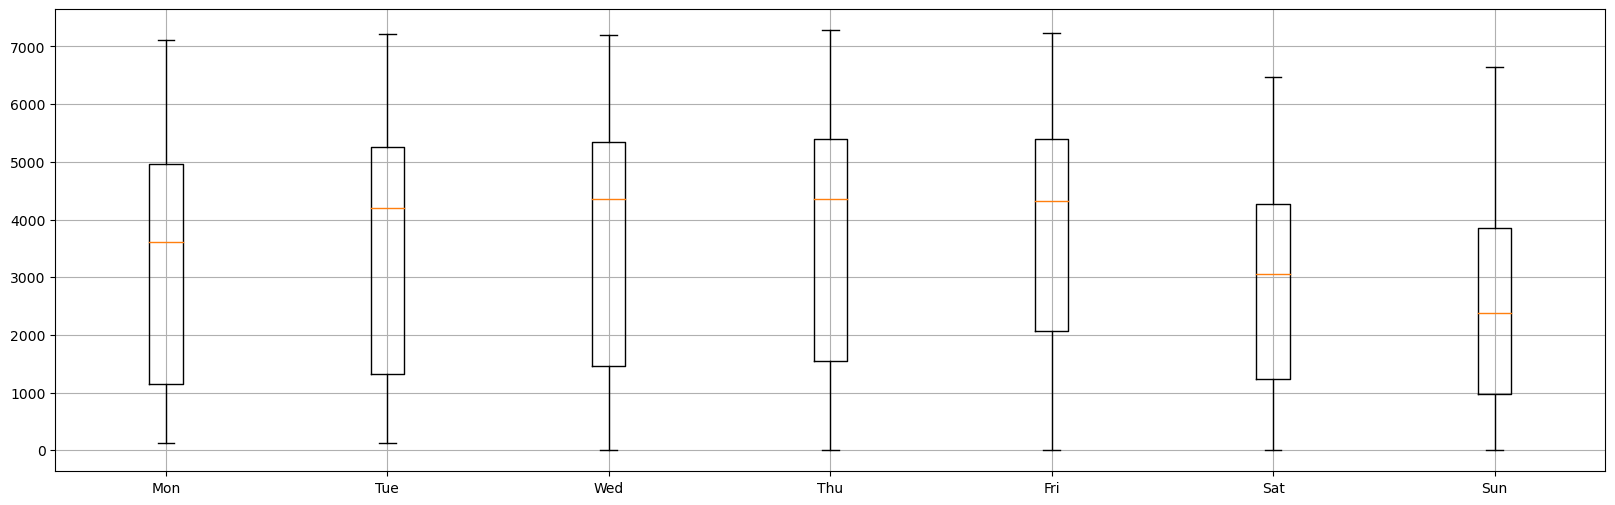

In [19]:
grouped = df.groupby(df['date_time'].dt.dayofweek)
positions = np.arange(len(grouped))

fig, ax = plt.subplots(figsize = (20,6))
for i, (day, data) in enumerate(grouped):
    ax.boxplot(data['traffic_volume'], positions=[positions[i]])
ax.grid(True)
ax.set_xticks(positions)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.tick_params(labelbottom=True)

распределение имеет три максимума


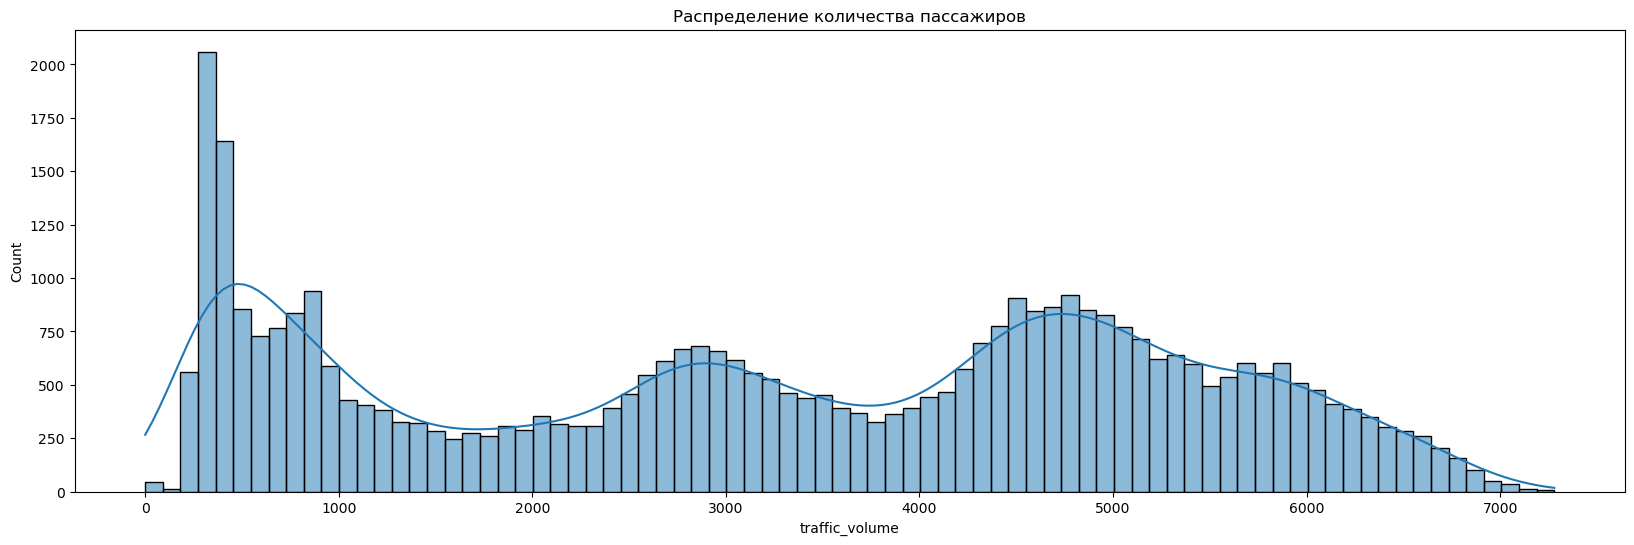

In [20]:
#histplot Распределение количества пассажиров
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(df[columns_view], bins=80, kde=True)
ax.set_title('Распределение количества пассажиров')
print(f'распределение имеет три максимума')

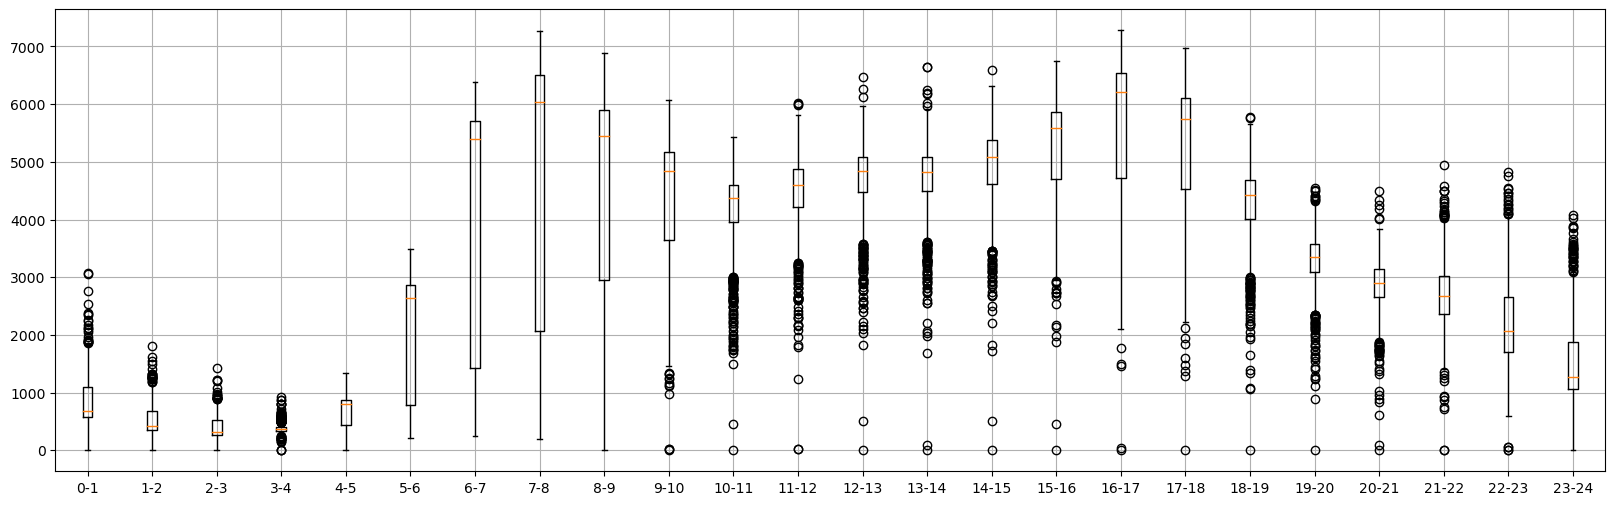

In [21]:
grouped = df.groupby(df['date_time'].dt.hour)
positions = np.arange(len(grouped))

fig, ax = plt.subplots(figsize = (20,6))
for i, (day, data) in enumerate(grouped):
    ax.boxplot(data['traffic_volume'], positions=[positions[i]])
ax.grid(True)
ax.set_xticks(positions)
ax.set_xticklabels(['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', 
                    '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', 
                    '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24'])
ax.tick_params(labelbottom=True)

In [22]:
columns_view = 'temp'

<Axes: xlabel='date_time'>

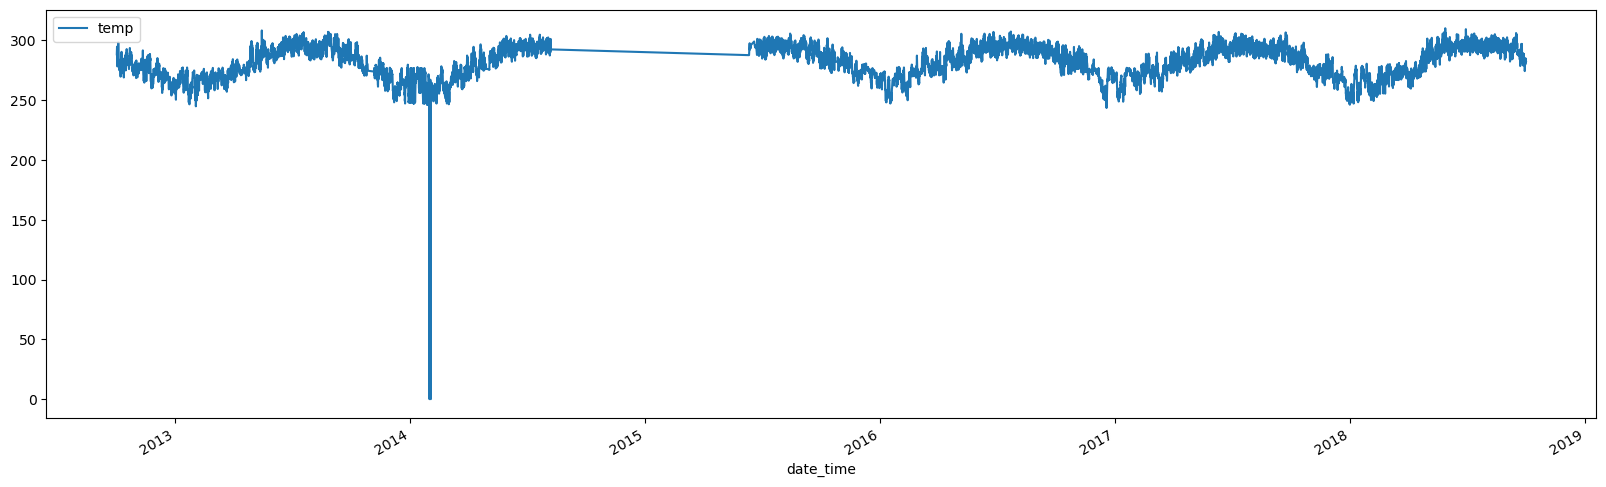

In [23]:
# График временного ряда y = 'temp'
df.set_index('date_time').plot(y = columns_view, figsize = (20,6))

temp
count    40575.000000
mean       281.316763
std         13.816618
min          0.000000
25%        271.840000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64


<Axes: >

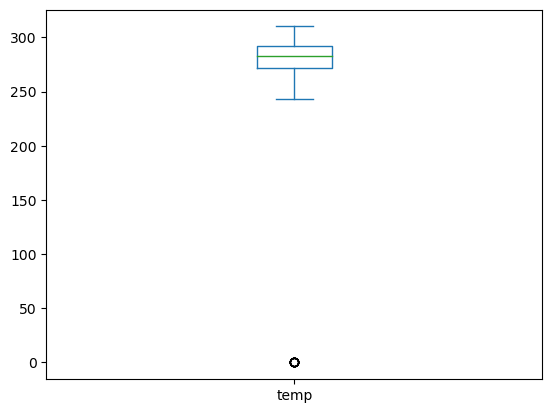

In [24]:
# boxplot y = 'temp'
print(df[columns_view].name)
print(df[columns_view].describe())
df.set_index('date_time').plot(y = columns_view, kind='box')

распределение имеет три максимума


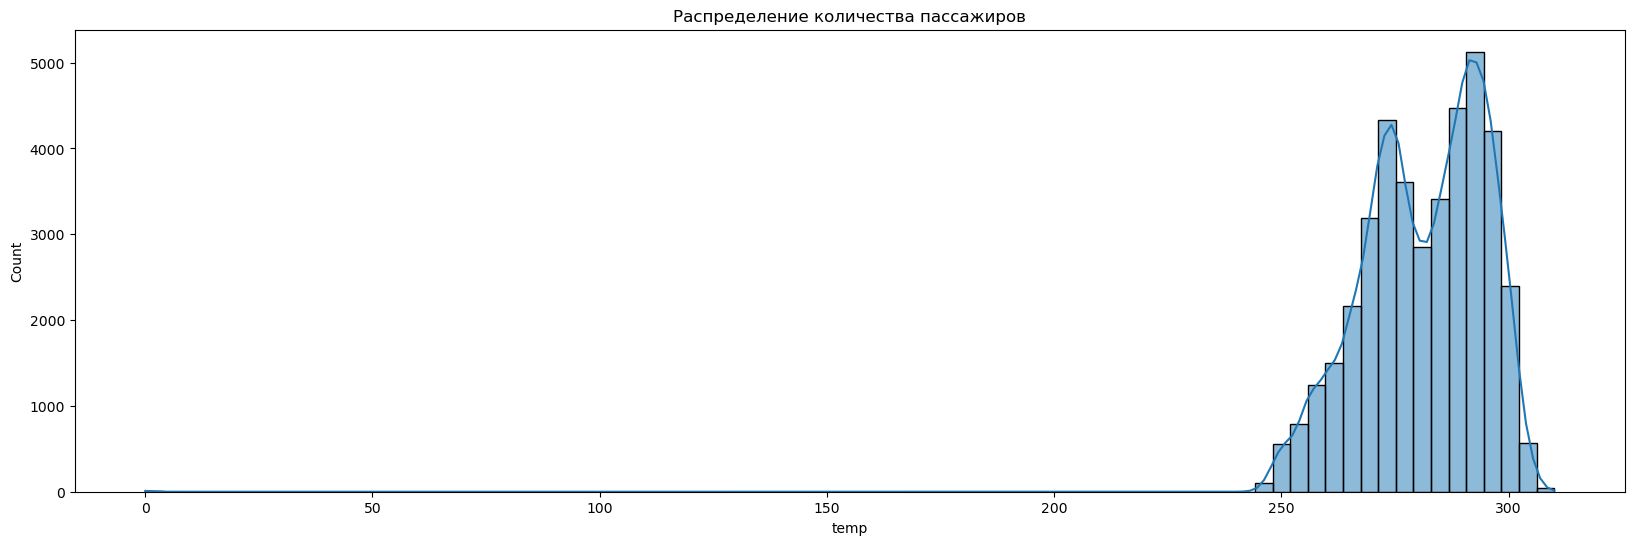

In [25]:
#histplot Распределение количества пассажиров
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(df[columns_view], bins=80, kde=True)
ax.set_title('Распределение количества пассажиров')
print(f'распределение имеет три максимума')

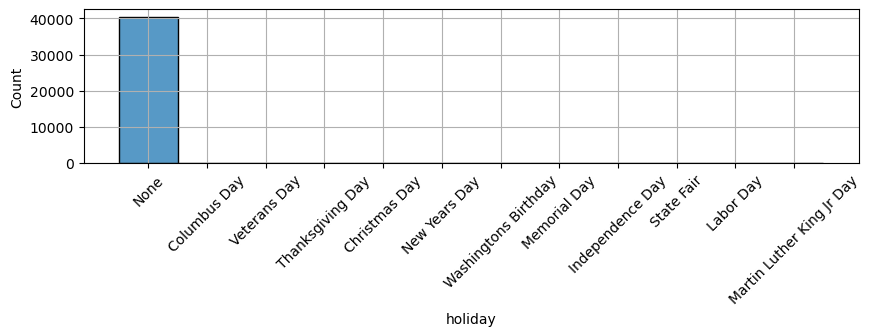

In [26]:
# Распределение 'holiday'
fig, ax = plt.subplots(figsize=(10, 2))
sns.histplot(df['holiday'], ax=ax)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [27]:
df['holiday'].value_counts(dropna=False)

None                         40522
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

In [28]:
df['holiday'].value_counts(dropna=False, normalize=True) #праздники можно заменить на 1, остальные дни заменить на 0

None                         0.998694
Columbus Day                 0.000123
Veterans Day                 0.000123
Thanksgiving Day             0.000123
Christmas Day                0.000123
New Years Day                0.000123
Washingtons Birthday         0.000123
Memorial Day                 0.000123
Independence Day             0.000123
State Fair                   0.000123
Labor Day                    0.000123
Martin Luther King Jr Day    0.000074
Name: holiday, dtype: float64

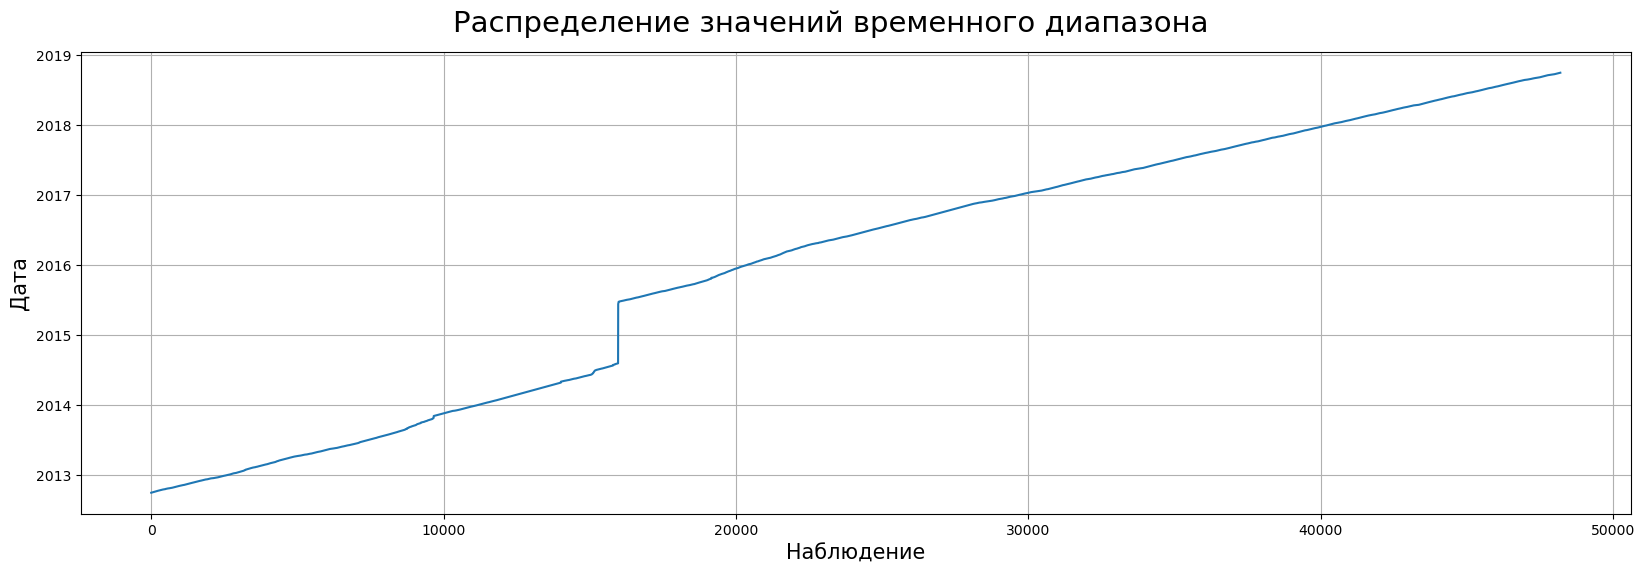

In [29]:
#непрерывность временного ряда?
df['date_time'].plot(figsize=(20, 6), grid=True)
plt.suptitle('Распределение значений временного диапазона', fontsize=21, y=0.95)
plt.xlabel('Наблюдение', fontsize=15)
plt.ylabel('Дата', fontsize=15)
plt.show()

### Вывод:
- проведена EDA: 
  - нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час
  - удалены дубликаты
  - распределение количества пассажиров имеет три максимума
  - распределение значений температуры воздуха имеет два выраженных максимума
  - праздники можно заменить на 1, остальные дни заменить на 0

### 2.2. Подготовка данных

- сгененрировать равномерную последовательность временных индексов
- интерполировать пропущенные значения
- праздники заменить на 1, остальные дни заменить на 0

In [30]:
# расчет числа часов между макимальной и минимальной датами
total_hours = (df['date_time'].max() - df['date_time'].min()).total_seconds()/3600 + 1
print(f"всего с {df['date_time'].min()} по {df['date_time'].max()} должно быть {total_hours} час")

всего с 2012-10-02 09:00:00 по 2018-09-30 23:00:00 должно быть 52551.0 час


In [31]:
lose_hours = total_hours - df['date_time'].shape[0]
print(f"число часов в дата-сете {df['date_time'].shape[0]} часов")
print(f'не хватает {lose_hours} часов')
print(f'не хватает {100*lose_hours/total_hours:.3f}%')

число часов в дата-сете 40575 часов
не хватает 11976.0 часов
не хватает 22.789%


Создам новый временной ряд и в него добавлю исходные данные
- создаю временной ряд df_time
- соединю df_time c df
- заполню пропуски для 'traffic_volume', 'temp' - интерполяцией, для 'holiday' - None

In [32]:
df_time = pd.DataFrame()
df_time['date_time'] = pd.date_range(df['date_time'].min(), periods = total_hours, freq = '1H')

In [33]:
df_time

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00
...,...
52546,2018-09-30 19:00:00
52547,2018-09-30 20:00:00
52548,2018-09-30 21:00:00
52549,2018-09-30 22:00:00


In [34]:
#в df создаю колонки _interpolate, для интеполирования данных
df['temp_interpolate'] = df['temp']
df['traffic_volume_interpolate'] = df['traffic_volume']

In [35]:
#запишем в df_base df_time и df
df_base = pd.merge(df_time, df, how = 'left', on = 'date_time')

In [36]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52551 entries, 0 to 52550
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date_time                   52551 non-null  datetime64[ns]
 1   traffic_volume              40575 non-null  float64       
 2   holiday                     40575 non-null  object        
 3   temp                        40575 non-null  float64       
 4   temp_interpolate            40575 non-null  float64       
 5   traffic_volume_interpolate  40575 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.8+ MB


In [37]:
df_base

,date_time,traffic_volume,holiday,temp,temp_interpolate,traffic_volume_interpolate
0,2012-10-02 09:00:00,5545.0,None,288.28,288.28,5545.0
1,2012-10-02 10:00:00,4516.0,None,289.36,289.36,4516.0
2,2012-10-02 11:00:00,4767.0,None,289.58,289.58,4767.0
3,2012-10-02 12:00:00,5026.0,None,290.13,290.13,5026.0
4,2012-10-02 13:00:00,4918.0,None,291.14,291.14,4918.0
...,...,...,...,...,...,...
52546,2018-09-30 19:00:00,3543.0,None,283.45,283.45,3543.0
52547,2018-09-30 20:00:00,2781.0,None,282.76,282.76,2781.0
52548,2018-09-30 21:00:00,2159.0,None,282.73,282.73,2159.0
52549,2018-09-30 22:00:00,1450.0,None,282.09,282.09,1450.0


In [38]:
#в интерполирую
df_base['temp_interpolate'].interpolate(method='linear', inplace = True)
df_base['traffic_volume_interpolate'].interpolate(method='linear', inplace = True)

array([<Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>],
      dtype=object)

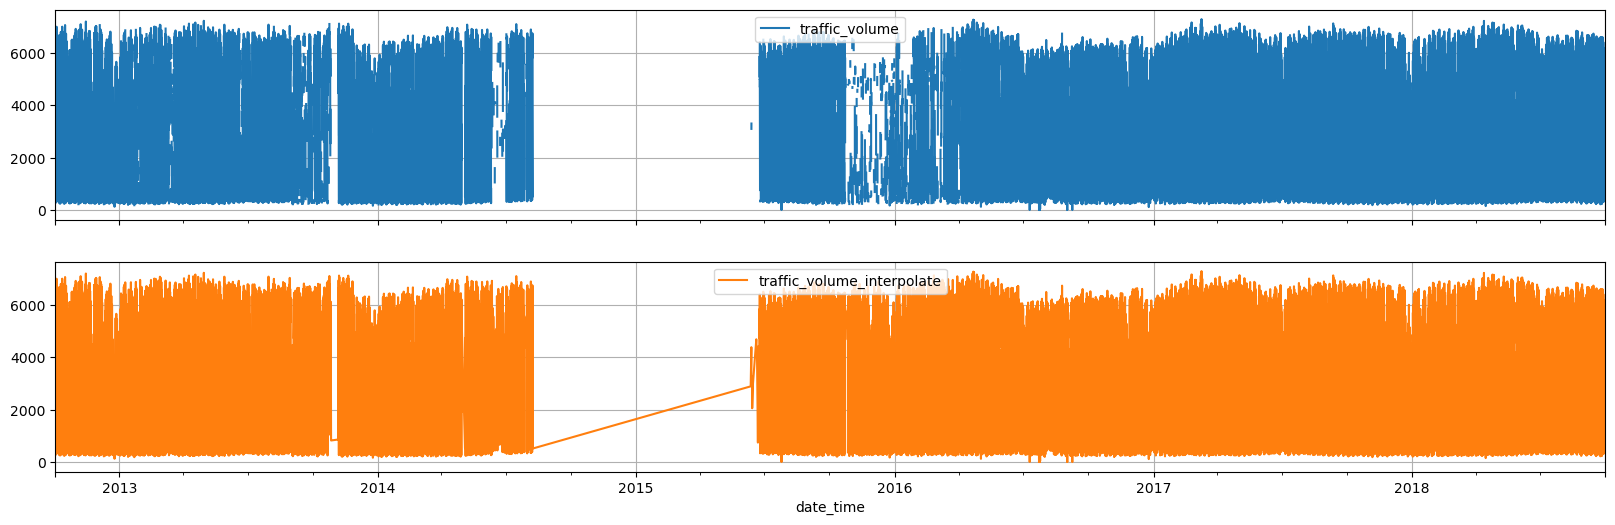

In [39]:
df_base.set_index('date_time').plot(y = ['traffic_volume', 'traffic_volume_interpolate'], 
                                    figsize = (20,6), grid = True, 
                                    subplots = True)

array([<Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>],
      dtype=object)

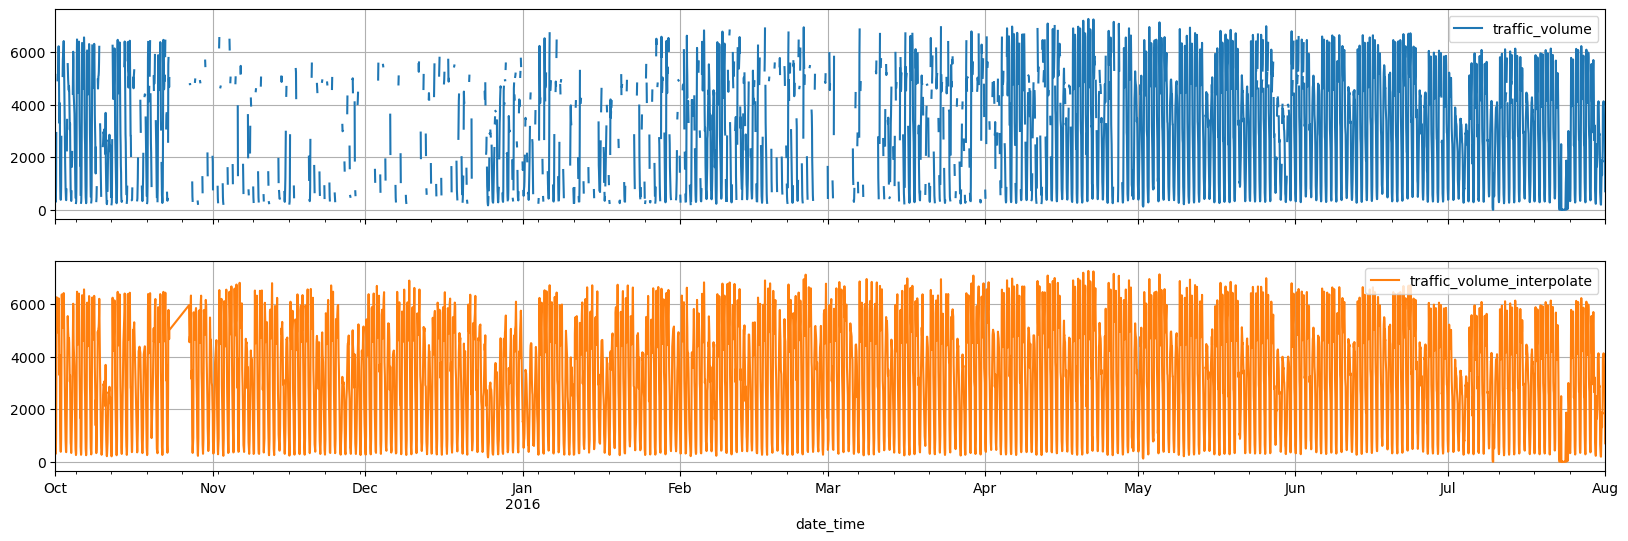

In [40]:
rol_start = '2015-10-1 00:00:00'
rol_finish = '2016-08-1 00:00:00'
df_base.set_index('date_time').loc[rol_start:rol_finish].plot(y = ['traffic_volume', 'traffic_volume_interpolate'],  
                                                              figsize = (20,6), 
                                                              grid = True,
                                                              subplots = True)

In [41]:
#праздники заменить на 1, остальные дни заменить на 0
df_base['holiday'].fillna('None', inplace = True)
df_base.loc[df_base['holiday'] != 'None', 'holiday'] = 1
df_base.loc[df_base['holiday'] == 'None', 'holiday'] = 0
df_base['holiday'].value_counts(dropna = False)

0    52498
1       53
Name: holiday, dtype: int64

In [42]:
df_base.columns

Index(['date_time', 'traffic_volume', 'holiday', 'temp', 'temp_interpolate',
       'traffic_volume_interpolate'],
      dtype='object')

In [43]:
#  дата-сет для моделирования
df_base = df_base[['date_time', 'holiday', 'temp_interpolate', 'traffic_volume_interpolate']]

In [44]:
df_base.head()

,date_time,holiday,temp_interpolate,traffic_volume_interpolate
0,2012-10-02 09:00:00,0,288.28,5545.0
1,2012-10-02 10:00:00,0,289.36,4516.0
2,2012-10-02 11:00:00,0,289.58,4767.0
3,2012-10-02 12:00:00,0,290.13,5026.0
4,2012-10-02 13:00:00,0,291.14,4918.0


#### Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.

In [45]:
df_base['date_time'].max()

Timestamp('2018-09-30 23:00:00')

In [46]:
two_weeks_ago = df_base['date_time'].max() - timedelta(days=14)

In [47]:
index_dt_test = df_base.loc[(df_base['date_time'] > two_weeks_ago) & (df_base['date_time'] <= df_base['date_time'].max())].index

In [48]:
df_test = df_base.iloc[index_dt_test].copy()

<Axes: xlabel='date_time'>

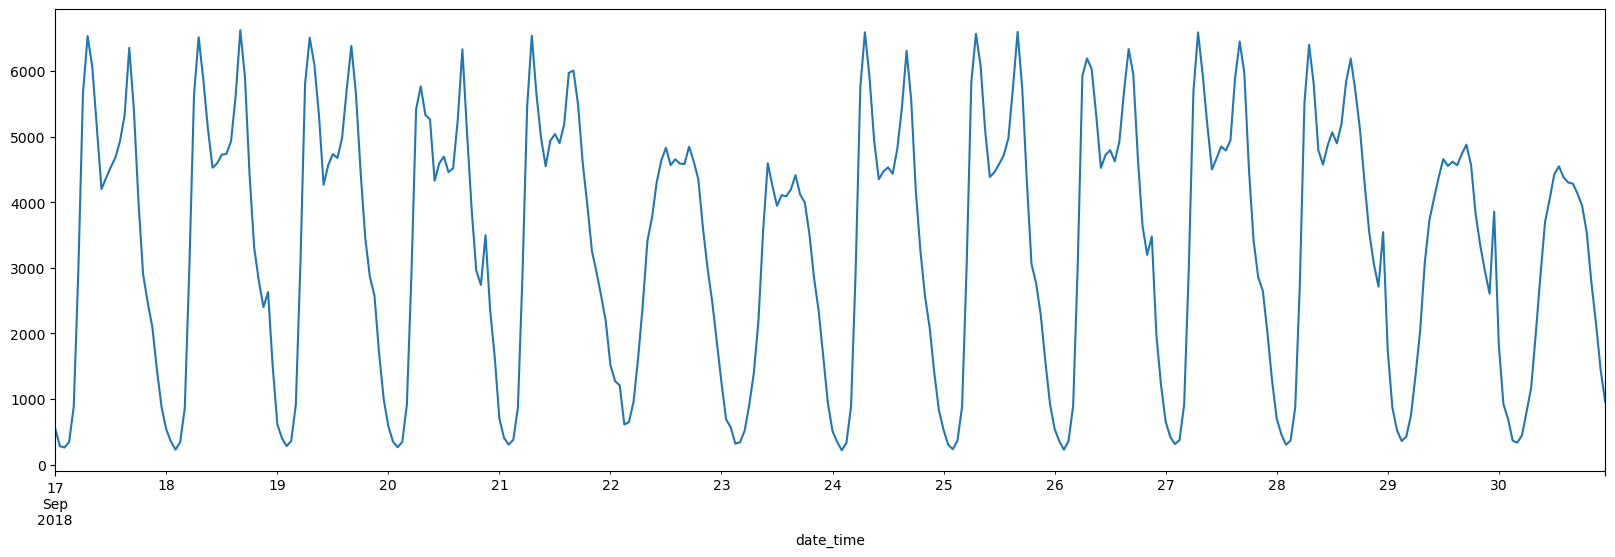

In [49]:
df_test.set_index('date_time')['traffic_volume_interpolate'].plot(figsize = (20,6))

#### Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.

In [50]:
df_train = df_base.loc[(df_base['date_time'] <= two_weeks_ago)].copy()

In [51]:
df_train.describe()

,temp_interpolate,traffic_volume_interpolate
count,52215.000000,52215.000000
mean,282.478451,3069.927655
std,13.023235,1922.241598
min,0.000000,0.000000
25%,273.510000,1222.898538
50%,286.410000,2891.000000
75%,291.720000,4775.000000
max,310.070000,7280.000000


In [52]:
#возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.
df_train.loc[df_train['date_time'].dt.year >= 2016].describe()

,temp_interpolate,traffic_volume_interpolate
count,23760.000000,23760.000000
mean,282.063330,3311.867024
std,12.718119,1963.516422
min,243.390000,0.000000
25%,272.650000,1309.875000
50%,283.815000,3505.000000
75%,292.570000,4938.000000
max,310.070000,7280.000000


оставим данные с 2016 г.

In [53]:
df_train = df_train.loc[df_train['date_time'].dt.year >= 2016].copy()

<Axes: xlabel='date_time'>

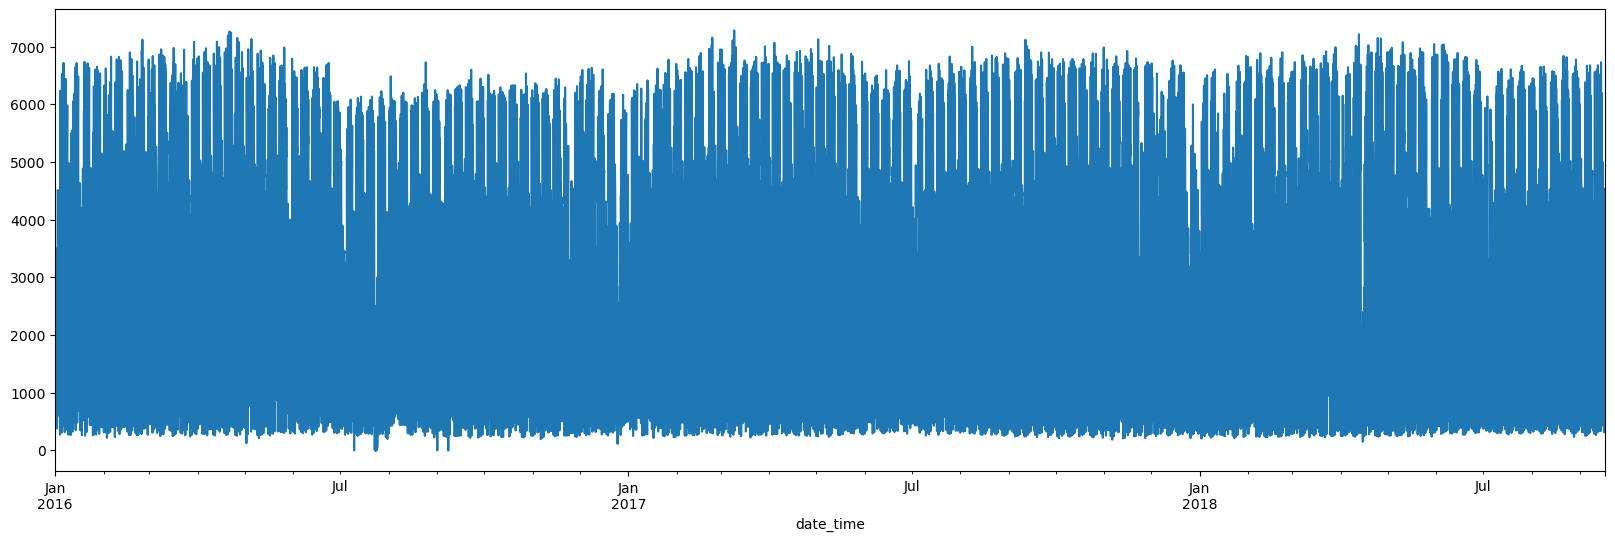

In [54]:
df_train.set_index('date_time')['traffic_volume_interpolate'].plot(figsize = (20,6))

In [55]:
df_train.loc[df_train['holiday'] == 1].describe()

,temp_interpolate,traffic_volume_interpolate
count,28.000000,28.000000
mean,279.710964,910.035714
std,13.532942,309.537466
min,249.360000,484.000000
25%,269.485000,648.500000
50%,283.480500,805.000000
75%,290.167500,1089.000000
max,299.487000,1538.000000


In [56]:
df_train.loc[df_train['holiday'] != 1].describe()['traffic_volume_interpolate']['25%']

1315.0

##### есть какие-то значения когда traffic_volume_interpolate = 0, исправим их. Буду подбираться к подозрительным значением через "приближение"

In [57]:
step = df_train.loc[df_train['traffic_volume_interpolate'] <= 
             df_train.loc[df_train['holiday'] != 1].describe()['traffic_volume_interpolate']['25%']].describe()['traffic_volume_interpolate']['25%']
step2 = df_train.loc[df_train['traffic_volume_interpolate'] <= step].describe()['traffic_volume_interpolate']['25%']
print(step)
print(step2)

368.0
281.0


In [58]:
df_train.loc[df_train['traffic_volume_interpolate'] <= step2].describe()

,temp_interpolate,traffic_volume_interpolate
count,377.000000,377.000000
mean,278.569597,225.098143
std,12.349213,81.118574
min,245.620000,0.000000
25%,270.860000,233.000000
50%,278.750000,255.000000
75%,287.900000,269.000000
max,300.880000,281.000000


In [59]:
step3 = df_train.loc[df_train['traffic_volume_interpolate'] <= step2].describe()['traffic_volume_interpolate']['25%']
step4 = df_train.loc[df_train['traffic_volume_interpolate'] <= step3].describe()['traffic_volume_interpolate']['50%']
print(step3)
print(step4)

233.0
157.0


In [60]:
df_train.loc[df_train['traffic_volume_interpolate'] <= step4].describe()

,temp_interpolate,traffic_volume_interpolate
count,48.000000,48.000000
mean,293.743125,22.750000
std,6.553268,40.296507
min,268.010000,0.000000
25%,294.050000,3.000000
50%,295.545000,6.500000
75%,296.702500,12.000000
max,300.880000,151.000000


###### вроде как все что меньше 157.0 - подозрительные, заменю интерполяцией

In [61]:
df_train.loc[df_train['traffic_volume_interpolate'] <= step4, 'traffic_volume_interpolate'] = np.nan
df_train['traffic_volume_interpolate'].interpolate(method='linear', inplace = True)

In [62]:
#Проверю на describe
df_train.describe()

,temp_interpolate,traffic_volume_interpolate
count,23760.000000,23760.000000
mean,282.063330,3314.255850
std,12.718119,1960.438315
min,243.390000,163.000000
25%,272.650000,1315.000000
50%,283.815000,3505.000000
75%,292.570000,4938.000000
max,310.070000,7280.000000


In [63]:
#исправил подозрительные значения
df_train

,date_time,holiday,temp_interpolate,traffic_volume_interpolate
28455,2016-01-01 00:00:00,1,265.940,1513.0
28456,2016-01-01 01:00:00,0,266.000,1550.0
28457,2016-01-01 02:00:00,0,266.005,1134.5
28458,2016-01-01 03:00:00,0,266.010,719.0
28459,2016-01-01 04:00:00,0,264.800,533.0
...,...,...,...,...
52210,2018-09-16 19:00:00,0,303.020,3400.0
52211,2018-09-16 20:00:00,0,300.780,3092.0
52212,2018-09-16 21:00:00,0,298.900,2623.0
52213,2018-09-16 22:00:00,0,297.850,1725.0


#### Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.

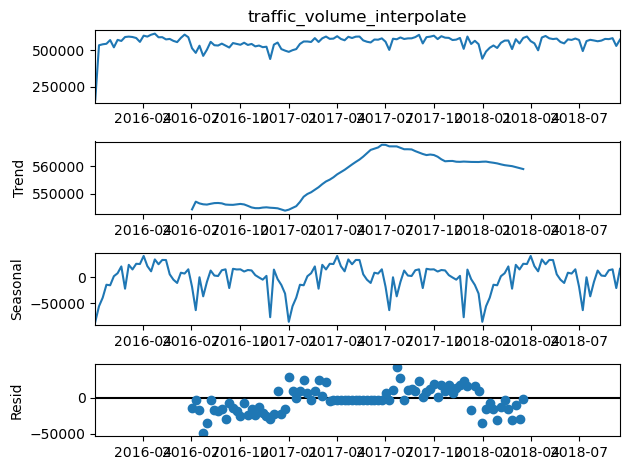

In [64]:
decomposition = sm.tsa.seasonal_decompose(df_train.set_index('date_time')['traffic_volume_interpolate'].resample('W').sum(), model='additive')
decomposition.plot()
plt.show()

Присутвует недельная сезонность, выделю признак dt.weekday

In [65]:
df_train['date_time_weekday'] = df_train['date_time'].dt.weekday

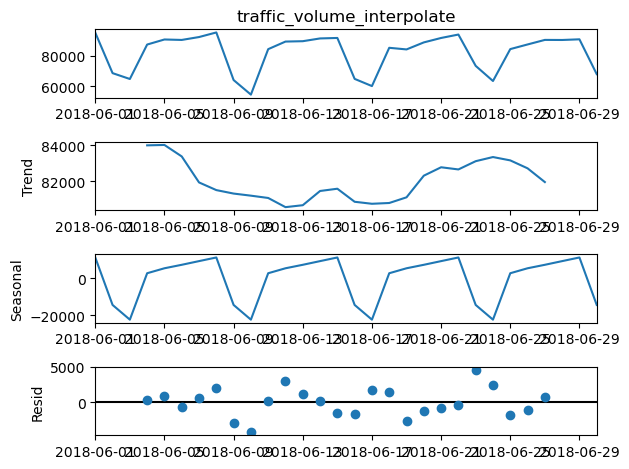

In [66]:
date_start_2018 = df_train.loc[(df_train['date_time'].dt.year== 2018) & (df_train['date_time'].dt.month== 6), 'date_time'].min()
date_finish_2018 = df_train.loc[(df_train['date_time'].dt.year== 2018) & (df_train['date_time'].dt.month== 6), 'date_time'].max()
decomposition = sm.tsa.seasonal_decompose(df_train.set_index('date_time').loc[date_start_2018:date_finish_2018, 'traffic_volume_interpolate'].resample('D').sum(), model='additive')
decomposition.plot()
plt.show()

Присутвует недельная сезонность, выделю признак dt.day

In [67]:
df_train['date_time_day'] = df_train['date_time'].dt.day

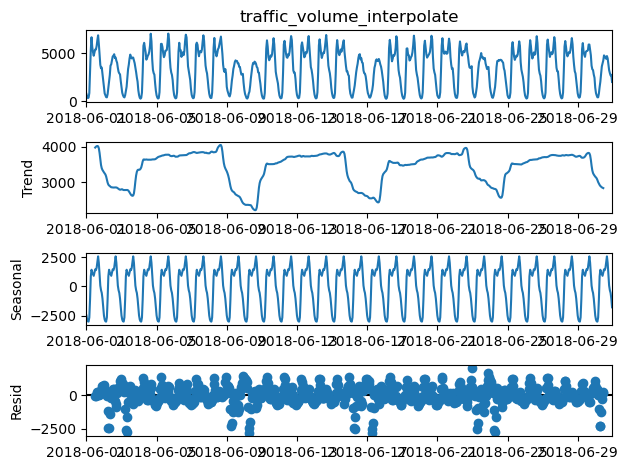

In [68]:
date_start_2018 = df_train.loc[(df_train['date_time'].dt.year== 2018) & (df_train['date_time'].dt.month== 6), 'date_time'].min()
date_finish_2018 = df_train.loc[(df_train['date_time'].dt.year== 2018) & (df_train['date_time'].dt.month== 6), 'date_time'].max()
decomposition = sm.tsa.seasonal_decompose(df_train.set_index('date_time').loc[date_start_2018:date_finish_2018, 'traffic_volume_interpolate'].resample('H').sum(), model='additive')
decomposition.plot()
plt.show()

Присутвует часовая сезонность, выделю признак dt.hour

In [69]:
df_train['date_time_hour'] = df_train['date_time'].dt.hour

In [70]:
df_train.set_index('date_time')

,holiday,temp_interpolate,traffic_volume_interpolate,date_time_weekday,date_time_day,date_time_hour
date_time,,,,,,
2016-01-01 00:00:00,1,265.940,1513.0,4,1,0
2016-01-01 01:00:00,0,266.000,1550.0,4,1,1
2016-01-01 02:00:00,0,266.005,1134.5,4,1,2
2016-01-01 03:00:00,0,266.010,719.0,4,1,3
2016-01-01 04:00:00,0,264.800,533.0,4,1,4
...,...,...,...,...,...,...
2018-09-16 19:00:00,0,303.020,3400.0,6,16,19
2018-09-16 20:00:00,0,300.780,3092.0,6,16,20
2018-09-16 21:00:00,0,298.900,2623.0,6,16,21


#### Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели,

- посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() 
- и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.

In [71]:
df_train['index'] = df_train.index

In [72]:
df_train

,date_time,holiday,temp_interpolate,traffic_volume_interpolate,date_time_weekday,date_time_day,date_time_hour,index
28455,2016-01-01 00:00:00,1,265.940,1513.0,4,1,0,28455
28456,2016-01-01 01:00:00,0,266.000,1550.0,4,1,1,28456
28457,2016-01-01 02:00:00,0,266.005,1134.5,4,1,2,28457
28458,2016-01-01 03:00:00,0,266.010,719.0,4,1,3,28458
28459,2016-01-01 04:00:00,0,264.800,533.0,4,1,4,28459
...,...,...,...,...,...,...,...,...
52210,2018-09-16 19:00:00,0,303.020,3400.0,6,16,19,52210
52211,2018-09-16 20:00:00,0,300.780,3092.0,6,16,20,52211
52212,2018-09-16 21:00:00,0,298.900,2623.0,6,16,21,52212
52213,2018-09-16 22:00:00,0,297.850,1725.0,6,16,22,52213


In [73]:
df_baseline_data = (df_train.groupby(['date_time_weekday', 'date_time_hour'])
                    [["traffic_volume_interpolate"]].mean().reset_index())

In [74]:
#df_test
df_test['date_time_weekday'] = df_test['date_time'].dt.weekday
df_test['date_time_day'] = df_test['date_time'].dt.day
df_test['date_time_hour'] = df_test['date_time'].dt.hour
df_test['index'] = df_test.index

In [75]:
#соединю df_test[['date_time', 'traffic_volume_interpolate', 'date_time_weekday', 'date_time_hour']]
#с df_baseline_data[['traffic_volume_interpolate', 'date_time_weekday', 'date_time_hour']]
#по колнокам on = ['date_time_weekday', 'date_time_hour']
#добавлю суфикс suffixes=['_y', '_y_pred']
#установлю индекс set_index('date_time'), отсортирую по индексу
#выберу колонки [['traffic_volume_interpolate_y','traffic_volume_interpolate_y_pred']]

df_baseline = pd.merge(df_test[['date_time', 'traffic_volume_interpolate', 'date_time_weekday', 'date_time_hour']], 
                      df_baseline_data[['traffic_volume_interpolate', 'date_time_weekday', 'date_time_hour']], 
                      on = ['date_time_weekday', 'date_time_hour'], 
                      suffixes=['_y', '_y_pred']).set_index('date_time').sort_index()[['traffic_volume_interpolate_y', 
                                                                                       'traffic_volume_interpolate_y_pred']]

In [76]:
#Средняя абсолютная процентная ошибка baseline-прогноза составляет
mape = abs((df_baseline['traffic_volume_interpolate_y_pred'] - df_baseline['traffic_volume_interpolate_y'])/df_baseline['traffic_volume_interpolate_y']).mean()

In [77]:
print(f'Средняя абсолютная процентная ошибка baseline-прогноза составляет: {100*mape:.2f} %')

Средняя абсолютная процентная ошибка baseline-прогноза составляет: 8.53 %


In [78]:
df_baseline

,traffic_volume_interpolate_y,traffic_volume_interpolate_y_pred
date_time,,
2018-09-17 00:00:00,550.0,653.773050
2018-09-17 01:00:00,280.0,406.445626
2018-09-17 02:00:00,260.0,308.057920
2018-09-17 03:00:00,344.0,369.205674
2018-09-17 04:00:00,880.0,856.579196
...,...,...
2018-09-30 19:00:00,3543.0,3165.874413
2018-09-30 20:00:00,2781.0,2803.302817
2018-09-30 21:00:00,2159.0,2379.338028


<Axes: xlabel='date_time'>

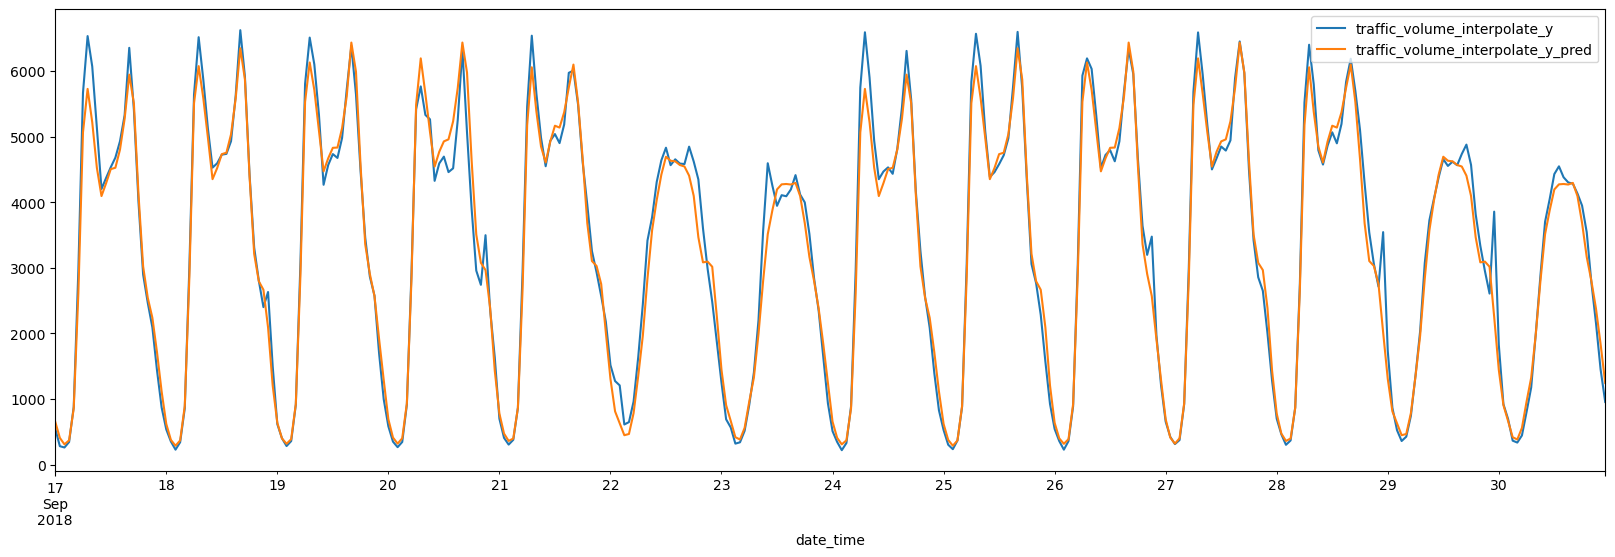

In [79]:
df_baseline.plot(y=['traffic_volume_interpolate_y', 'traffic_volume_interpolate_y_pred'], figsize=(20,6))

### CatBoostRegressor

In [80]:
# Шаг 1: Создание переменной y для предсказания
y = df_train['traffic_volume_interpolate']

# Шаг 2: Создание X, признаков
X = df_train[['holiday', 'temp_interpolate', 'date_time_weekday', 'date_time_day', 'date_time_hour', 'index']]

# Шаг 3: Масштабирование признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Шаг 4: Создание модели CatBoost
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=100)

# Шаг 5: Обучение модели
model.fit(X_scaled, y)

# Шаг 6: Вывод результатов
predictions = model.predict(X_scaled)

# Шаг 7: Вывод ошибок
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, predictions)
print("Mean Absolute Error:", mae)

0:	learn: 1552.0685527	total: 141ms	remaining: 2m 20s
100:	learn: 253.0975501	total: 380ms	remaining: 3.38s
200:	learn: 225.6192147	total: 618ms	remaining: 2.46s
300:	learn: 214.2862236	total: 858ms	remaining: 1.99s
400:	learn: 205.7911226	total: 1.1s	remaining: 1.64s
500:	learn: 199.6888858	total: 1.34s	remaining: 1.33s
600:	learn: 194.8214579	total: 1.58s	remaining: 1.05s
700:	learn: 190.9466900	total: 1.82s	remaining: 776ms
800:	learn: 186.9230442	total: 2.06s	remaining: 512ms
900:	learn: 183.9961193	total: 2.3s	remaining: 253ms
999:	learn: 181.4744910	total: 2.54s	remaining: 0us
Mean Absolute Error: 181.47449203931365


In [81]:
df_train['traffic_volume_interpolate_pred'] = predictions

In [82]:
#Средняя абсолютная процентная ошибка CatBoostRegressor-прогноза на трайне составляет
df_train['traffic_volume_interpolate_abs'] = df_train['traffic_volume_interpolate_pred'] - df_train['traffic_volume_interpolate']
df_train['traffic_volume_interpolate_abs'] = np.abs(df_train['traffic_volume_interpolate_abs'])
df_train['traffic_volume_interpolate_mape'] = df_train['traffic_volume_interpolate_abs'] / df_train['traffic_volume_interpolate']

In [83]:
df_train['traffic_volume_interpolate_mape'].mean()

0.08088884232512647

###### Протестирую CatBoostRegressor на test

In [84]:
X_test = df_test[['holiday', 'temp_interpolate', 'date_time_weekday', 'date_time_day', 'date_time_hour', 'index']]

In [85]:
X_test_scaled = scaler.transform(X_test)

In [86]:
predictions_test = model.predict(X_test_scaled)

In [87]:
predictions_test

array([ 624.12286208,  386.46582872,  314.35075428,  368.79261667,
        888.61258394, 2966.54560114, 5667.72120821, 6110.91367632,
       5567.1262596 , 4591.97233894, 3952.53314627, 4449.93613359,
       4613.05957636, 4571.0585465 , 4844.44734392, 5479.61201594,
       6308.96550513, 5676.17217286, 4165.13493499, 3108.00824044,
       2586.96801894, 2191.68952497, 1514.69989941,  920.95467467,
        531.0207366 ,  304.17273791,  236.79074909,  314.40482938,
        904.70559511, 3061.44701077, 5827.8146587 , 6547.6733677 ,
       6024.99577309, 5196.52206732, 4556.16779326, 4688.91122671,
       4821.13610056, 4805.62129932, 5100.19226264, 5677.37895908,
       6482.83616188, 5868.7475376 , 4390.71372041, 3322.02707437,
       2809.10592731, 2441.51729395, 1772.37003451, 1027.54790238,
        574.60590286,  361.84594877,  297.53827987,  368.34906447,
        962.06645603, 3117.21440949, 5878.51583624, 6604.92448693,
       6117.66267203, 5337.09441635, 4699.56032581, 4873.33197

In [88]:
df_test['traffic_volume_interpolate_pred'] = predictions_test

In [89]:
#Средняя абсолютная процентная ошибка CatBoostRegressor-прогноза составляет
df_test['traffic_volume_interpolate_abs'] = df_test['traffic_volume_interpolate_pred'] - df_test['traffic_volume_interpolate']
df_test['traffic_volume_interpolate_abs'] = np.abs(df_test['traffic_volume_interpolate_abs'])
df_test['traffic_volume_interpolate_mape'] = df_test['traffic_volume_interpolate_abs'] / df_test['traffic_volume_interpolate']

In [90]:
mape_catb = df_test['traffic_volume_interpolate_mape'].mean()

In [91]:
print(f'Средняя абсолютная процентная ошибка CatBoostRegressor-прогноза составляет: {100*mape_catb:.2f} %')

Средняя абсолютная процентная ошибка CatBoostRegressor-прогноза составляет: 8.14 %


<Axes: xlabel='date_time'>

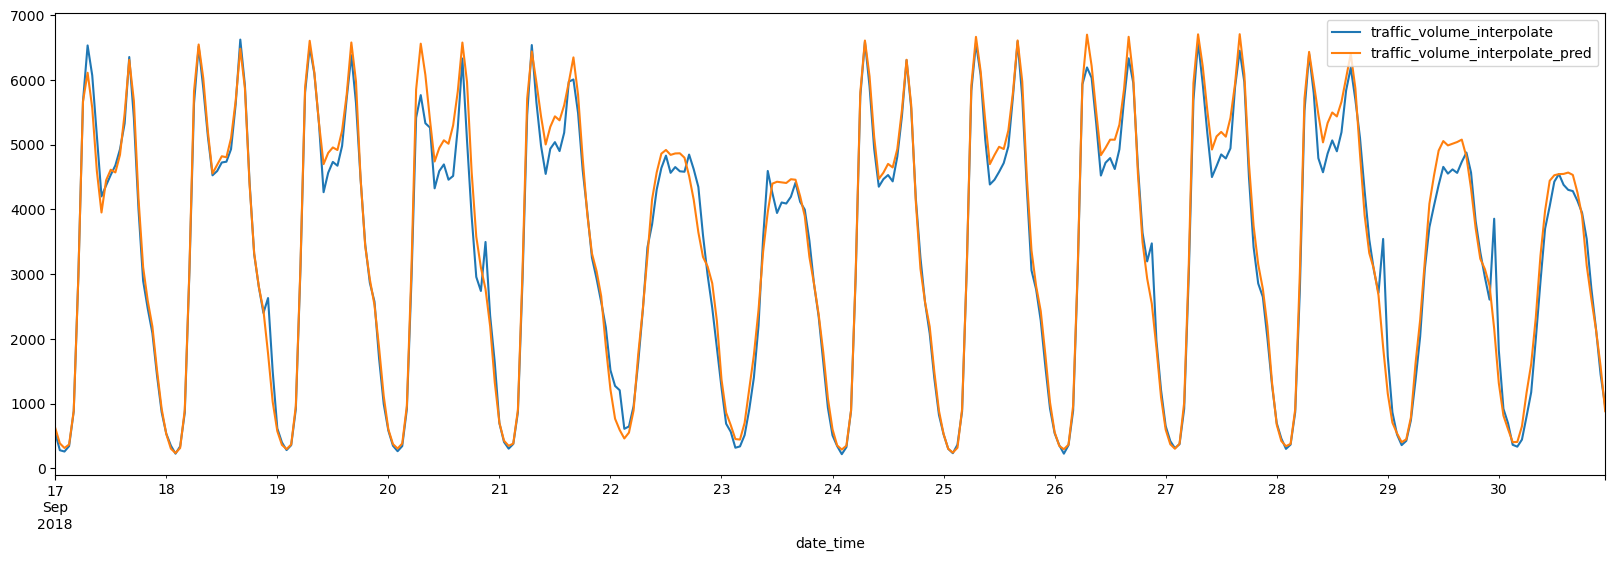

In [92]:
df_test.set_index('date_time').plot(y=['traffic_volume_interpolate', 'traffic_volume_interpolate_pred'], figsize=(20,6))

#### А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза. Несколько советов:

- для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
- попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.

Для начала необходимо провести анализ временного ряда 'temp_interpolate' с помощью графиков автокорреляции и частичной автокорреляции, чтобы определить параметры модели SARIMA (p, d, q) и (P, D, Q, s). 

Параметры p, d и q определяются на основе автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF). Параметры P, D, Q и s определяются на основе сезонной автокорреляционной функции (SACF) и сезонной частичной автокорреляционной функции (SPACF).

После определения параметров модели SARIMA, можно использовать методы поиска по сетке или оптимизации, такие как метод наименьших квадратов (МНК) или метод максимального правдоподобия, чтобы подобрать оптимальные значения коэффициентов модели SARIMA.

Также можно использовать информационные критерии, такие как AIC (критерий Акаике) или BIC (критерий Шварца), чтобы выбрать наилучшую модель SARIMA из нескольких вариантов.

После подбора коэффициентов модели SARIMA можно обучить модель на обучающем наборе данных df_train и использовать ее для прогнозирования временного ряда 'temp_interpolate'.

In [93]:
df_train

,date_time,holiday,temp_interpolate,traffic_volume_interpolate,date_time_weekday,date_time_day,date_time_hour,index,traffic_volume_interpolate_pred,traffic_volume_interpolate_abs,traffic_volume_interpolate_mape
28455,2016-01-01 00:00:00,1,265.940,1513.0,4,1,0,28455,1576.751069,63.751069,0.042136
28456,2016-01-01 01:00:00,0,266.000,1550.0,4,1,1,28456,578.729535,971.270465,0.626626
28457,2016-01-01 02:00:00,0,266.005,1134.5,4,1,2,28457,433.504834,700.995166,0.617889
28458,2016-01-01 03:00:00,0,266.010,719.0,4,1,3,28458,367.970616,351.029384,0.488219
28459,2016-01-01 04:00:00,0,264.800,533.0,4,1,4,28459,51.745455,481.254545,0.902917
...,...,...,...,...,...,...,...,...,...,...,...
52210,2018-09-16 19:00:00,0,303.020,3400.0,6,16,19,52210,3356.192509,43.807491,0.012885
52211,2018-09-16 20:00:00,0,300.780,3092.0,6,16,20,52211,3048.002467,43.997533,0.014229
52212,2018-09-16 21:00:00,0,298.900,2623.0,6,16,21,52212,2527.089350,95.910650,0.036565
52213,2018-09-16 22:00:00,0,297.850,1725.0,6,16,22,52213,1828.469011,103.469011,0.059982


C:\Users\smndy\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


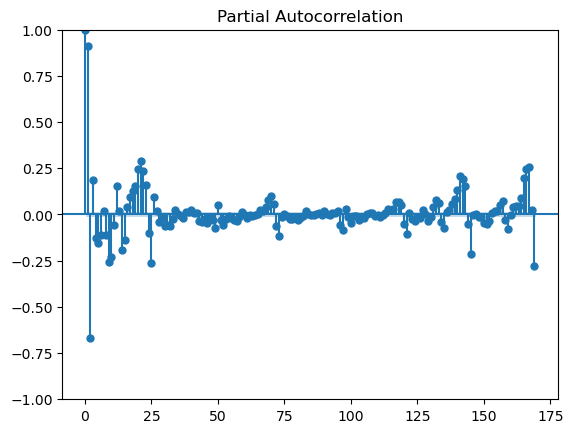

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Строим график частичной автокорреляции
plot_pacf(df_train['traffic_volume_interpolate'], lags=24*7+1)
plt.show()

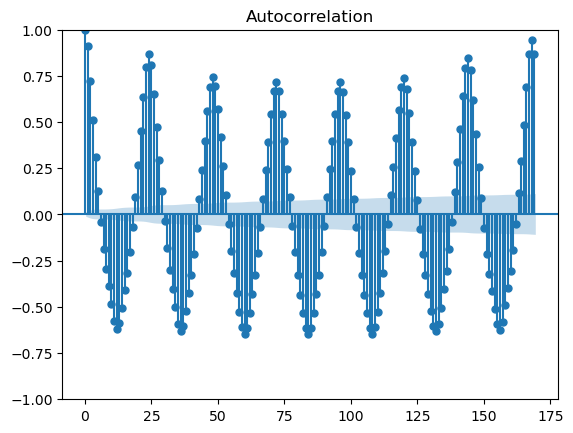

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Строим график частичной автокорреляции
plot_acf(df_train['traffic_volume_interpolate'], lags=24*7+1)
plt.show()

In [96]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

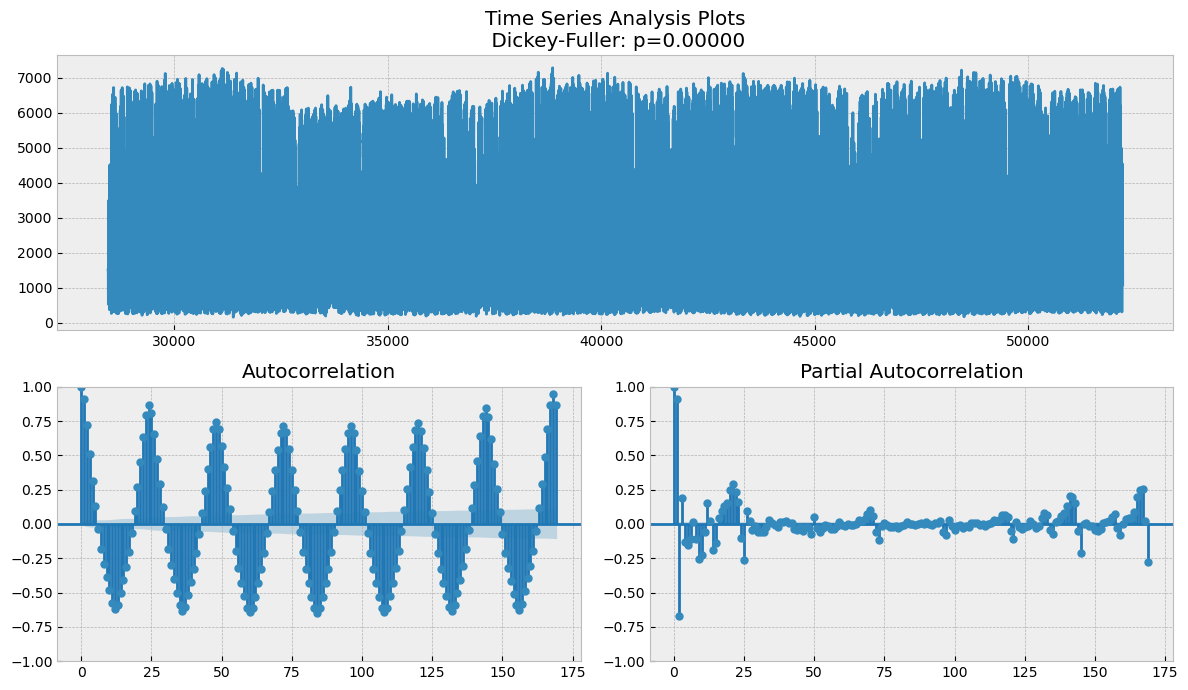

In [97]:
tsplot(df_train['traffic_volume_interpolate'], lags=24*7+1)

In [98]:
df_train.head(3)

,date_time,holiday,temp_interpolate,traffic_volume_interpolate,date_time_weekday,date_time_day,date_time_hour,index,traffic_volume_interpolate_pred,traffic_volume_interpolate_abs,traffic_volume_interpolate_mape
28455,2016-01-01 00:00:00,1,265.940,1513.0,4,1,0,28455,1576.751069,63.751069,0.042136
28456,2016-01-01 01:00:00,0,266.000,1550.0,4,1,1,28456,578.729535,971.270465,0.626626
28457,2016-01-01 02:00:00,0,266.005,1134.5,4,1,2,28457,433.504834,700.995166,0.617889


In [99]:
"""

#подберу опитимальные параметры через from pmdarima import auto_arima

%time
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_train.set_index('date_time')['traffic_volume_interpolate'], trace = True,
                          seasonal = True, m = 24*7,
                          start_P = 0, start_Q = 0,
                          max_P = 2, max_Q = 2,
                          
                          max_d = 2, max_D = 2,
                          alpha = 0.01,
                          
                          start_p = 1, start_q = 1,
                          max_p = 5, max_q = 7,
                          
                          test = 'kpss',
                          seasonal_test = 'ocsb',
                          
                          stepwise = True,
                          error_action = 'ignore',
                          n_fits = 30,
                          suppress_warnings=True,     
                          information_criterion='aic',
                          out_of_sample_size=7)
"""

"\n\n#подберу опитимальные параметры через from pmdarima import auto_arima\n\n%time\nfrom pmdarima import auto_arima\nstepwise_fit = auto_arima(df_train.set_index('date_time')['traffic_volume_interpolate'], trace = True,\n                          seasonal = True, m = 24*7,\n                          start_P = 0, start_Q = 0,\n                          max_P = 2, max_Q = 2,\n                          \n                          max_d = 2, max_D = 2,\n                          alpha = 0.01,\n                          \n                          start_p = 1, start_q = 1,\n                          max_p = 5, max_q = 7,\n                          \n                          test = 'kpss',\n                          seasonal_test = 'ocsb',\n                          \n                          stepwise = True,\n                          error_action = 'ignore',\n                          n_fits = 30,\n                          suppress_warnings=True,     \n                          informa

CPU times: total: 0 ns
Wall time: 0 ns
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[168] intercept   : AIC=373114.504, Time=6.24 sec
 ARIMA(0,0,0)(0,0,0)[168] intercept   : AIC=427676.438, Time=0.41 sec
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
Cell In[99], line 5
      3 get_ipython().run_line_magic('time', '')
      4 from pmdarima import auto_arima
----> 5 stepwise_fit = auto_arima(df_train.set_index('date_time')['traffic_volume_interpolate'], trace = True,
      6                           seasonal = True, m = 24*7,
      7                           start_P = 0, start_Q = 0,
      8                           max_P = 2, max_Q = 2,
      9                           
     10                           max_d = 2, max_D = 2,
     11                           alpha = 0.01,
     12                           
     13                           start_p = 1, start_q = 1,
     14                           max_p = 5, max_q = 7,
     15                           
     16                           test = 'kpss',
     17                           seasonal_test = 'ocsb',
     18                           
     19                           stepwise = True,
     20                           error_action = 'ignore',
     21                           n_fits = 30,
     22                           suppress_warnings=True,     
     23                           information_criterion='aic',
     24                           out_of_sample_size=7)

File ~\anaconda3\lib\site-packages\pmdarima\arima\auto.py:701, in auto_arima(y, X, start_p, d, start_q, max_p, max_d, max_q, start_P, D, start_Q, max_P, max_D, max_Q, max_order, m, seasonal, stationary, information_criterion, alpha, test, seasonal_test, stepwise, n_jobs, start_params, trend, method, maxiter, offset_test_args, seasonal_test_args, suppress_warnings, error_action, trace, random, random_state, n_fits, return_valid_fits, out_of_sample_size, scoring, scoring_args, with_intercept, sarimax_kwargs, **fit_args)
    669     # init the stepwise model wrapper
    670     search = solvers._StepwiseFitWrapper(
    671         y,
    672         X=X,
   (...)
    698         **sarimax_kwargs,
    699     )
--> 701 sorted_res = search.solve()
    702 return _return_wrapper(sorted_res, return_valid_fits, start, trace)

File ~\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:298, in _StepwiseFitWrapper.solve(self)
    296 _p = 1 if max_p > 0 else 0
    297 _P = 1 if (m > 1 and max_P > 0) else 0
--> 298 if self._do_fit((_p, d, 0), (_P, D, 0, m)):
    299     p = _p
    300     P = _P

File ~\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:235, in _StepwiseFitWrapper._do_fit(self, order, seasonal_order, constant)
    230 if (order, seasonal_order, constant) not in self.results_dict:
    231 
    232     # increment the number of fits
    233     self.k += 1
--> 235     fit, fit_time, new_ic = self._fit_arima(
    236         order=order,
    237         seasonal_order=seasonal_order,
    238         with_intercept=constant)
    240     # use the orders as a key to be hashed for
    241     # the dictionary (pointing to fit)
    242     self.results_dict[(order, seasonal_order, constant)] = fit

File ~\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:508, in _fit_candidate_model(y, X, order, seasonal_order, start_params, trend, method, maxiter, fit_params, suppress_warnings, trace, error_action, out_of_sample_size, scoring, scoring_args, with_intercept, information_criterion, **kwargs)
    500 fit = ARIMA(order=order, seasonal_order=seasonal_order,
    501             start_params=start_params, trend=trend, method=method,
    502             maxiter=maxiter, suppress_warnings=suppress_warnings,
    503             out_of_sample_size=out_of_sample_size, scoring=scoring,
    504             scoring_args=scoring_args,
    505             with_intercept=with_intercept, **kwargs)
    507 try:
--> 508     fit.fit(y, X=X, **fit_params)
    510 # for non-stationarity errors or singular matrices, return None
    511 except (LinAlgError, ValueError) as v:

File ~\anaconda3\lib\site-packages\pmdarima\arima\arima.py:618, in ARIMA.fit(self, y, X, **fit_args)
    613     self.oob_preds_ = pred
    615     # If we compute out of sample scores, we have to now update the
    616     # observed time points so future forecasts originate from the end
    617     # of our y vec
--> 618     self.update(cv_samples, cv_exog, **fit_args)
    619 else:
    620     self.oob_ = np.nan

File ~\anaconda3\lib\site-packages\pmdarima\arima\arima.py:973, in ARIMA.update(self, y, X, maxiter, **kwargs)
    968 # Get the model parameters, then we have to "fit" a new one. If you're
    969 # reading this source code, don't panic! We're not just fitting a new
    970 # arbitrary model. Statsmodels does not handle patching new samples in
    971 # very well, so we seed the new model with the existing parameters.
    972 params = model_res.params
--> 973 self._fit(y, X_prime, start_params=params, maxiter=maxiter, **kwargs)
    975 # Behaves like `fit`
    976 return self

File ~\anaconda3\lib\site-packages\pmdarima\arima\arima.py:524, in ARIMA._fit(self, y, X, **fit_args)
    522     with warnings.catch_warnings(record=False):
    523         warnings.simplefilter('ignore')
--> 524         fit, self.arima_res_ = _fit_wrapper()
    525 else:
    526     fit, self.arima_res_ = _fit_wrapper()

File ~\anaconda3\lib\site-packages\pmdarima\arima\arima.py:510, in ARIMA._fit.<locals>._fit_wrapper()
    507 _maxiter = fit_args.pop("maxiter", _maxiter)
    509 disp = fit_args.pop("disp", 0)
--> 510 fitted = arima.fit(
    511     start_params=start_params,
    512     method=method,
    513     maxiter=_maxiter,
    514     disp=disp,
    515     **fit_args,
    516 )
    518 return arima, fitted

File ~\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:728, in MLEModel.fit(self, start_params, transformed, includes_fixed, cov_type, cov_kwds, method, maxiter, full_output, disp, callback, return_params, optim_score, optim_complex_step, optim_hessian, flags, low_memory, **kwargs)
    726 else:
    727     func = self.smooth
--> 728 res = func(mlefit.params, transformed=False, includes_fixed=False,
    729            cov_type=cov_type, cov_kwds=cov_kwds)
    731 res.mlefit = mlefit
    732 res.mle_retvals = mlefit.mle_retvals

File ~\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:886, in MLEModel.smooth(self, params, transformed, includes_fixed, complex_step, cov_type, cov_kwds, return_ssm, results_class, results_wrapper_class, **kwargs)
    883     kwargs['inversion_method'] = INVERT_UNIVARIATE | SOLVE_LU
    885 # Get the state space output
--> 886 result = self.ssm.smooth(complex_step=complex_step, **kwargs)
    888 # Wrap in a results object
    889 return self._wrap_results(params, result, return_ssm, cov_type,
    890                           cov_kwds, results_class,
    891                           results_wrapper_class)

File ~\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_smoother.py:401, in KalmanSmoother.smooth(self, smoother_output, smooth_method, results, run_filter, prefix, complex_step, update_representation, update_filter, update_smoother, **kwargs)
    399     results.update_representation(self)
    400 if update_filter:
--> 401     results.update_filter(kfilter)
    402 else:
    403     # (even if we don't update all filter results, still need to
    404     # update this)
    405     results.nobs_diffuse = kfilter.nobs_diffuse

File ~\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1545, in FilterResults.update_filter(self, kalman_filter)
   1542 self.period_converged = kalman_filter.period_converged
   1544 self.filtered_state = np.array(kalman_filter.filtered_state, copy=True)
-> 1545 self.filtered_state_cov = np.array(
   1546     kalman_filter.filtered_state_cov, copy=True
   1547 )
   1548 self.predicted_state = np.array(
   1549     kalman_filter.predicted_state, copy=True
   1550 )
   1551 self.predicted_state_cov = np.array(
   1552     kalman_filter.predicted_state_cov, copy=True
   1553 )

MemoryError: Unable to allocate 5.06 GiB for an array with shape (169, 169, 23760) and data type float64


#### Для всего дата-сета не хвататет памяти, подберу для 360 последних значений

In [100]:
#подберу опитимальные параметры через from pmdarima import auto_arima для 360 последних значений

%time
from pmdarima import auto_arima
stepwise_fit_crop = auto_arima(df_train.set_index('date_time')['traffic_volume_interpolate'].tail(24*15), trace = True,
                               seasonal = True, m = 24*7,
                               start_P = 0, start_Q = 0,
                               max_P = 2, max_Q = 2,
                               max_d = 2, max_D = 2,
                               alpha = 0.01,
                               start_p = 1, start_q = 1,
                               max_p = 5, max_q = 7,
                               test = 'kpss',
                               seasonal_test = 'ocsb',
                               stepwise = True,
                               error_action = 'ignore',
                               n_fits = 30,
                               suppress_warnings=True,     
                               information_criterion='aic',
                               out_of_sample_size=7)

CPU times: total: 0 ns
Wall time: 0 ns
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[168] intercept   : AIC=2883.629, Time=20.78 sec
 ARIMA(0,0,0)(0,1,0)[168] intercept   : AIC=3077.652, Time=6.34 sec
 ARIMA(1,0,0)(1,1,0)[168] intercept   : AIC=2891.161, Time=155.07 sec
 ARIMA(0,0,1)(0,1,1)[168] intercept   : AIC=2954.615, Time=201.70 sec
 ARIMA(0,0,0)(0,1,0)[168]             : AIC=3092.232, Time=5.23 sec
 ARIMA(1,0,1)(1,1,0)[168] intercept   : AIC=2885.625, Time=177.63 sec
 ARIMA(1,0,1)(0,1,1)[168] intercept   : AIC=2885.623, Time=168.62 sec
 ARIMA(1,0,1)(1,1,1)[168] intercept   : AIC=inf, Time=305.83 sec
 ARIMA(0,0,1)(0,1,0)[168] intercept   : AIC=2952.365, Time=40.30 sec
 ARIMA(1,0,0)(0,1,0)[168] intercept   : AIC=2889.301, Time=24.47 sec
 ARIMA(2,0,1)(0,1,0)[168] intercept   : AIC=2881.801, Time=45.22 sec
 ARIMA(2,0,1)(1,1,0)[168] intercept   : AIC=2883.873, Time=251.81 sec
 ARIMA(2,0,1)(0,1,1)[168] intercept   : AIC=2883.893, Time=201.67 sec
 ARIMA(2,0,1)(1,1,1)[

In [101]:
#df_train.set_index('date_time')['traffic_volume_interpolate'].tail(24*15) - осуществлен подбор параметров 
#для 360 последних значений

df_train.set_index('date_time')['traffic_volume_interpolate'].tail(24*15).describe()

count     360.000000
mean     3227.375000
std      1938.282329
min       254.000000
25%      1266.750000
50%      3407.000000
75%      4760.500000
max      6728.000000
Name: traffic_volume_interpolate, dtype: float64

In [102]:
df_train.set_index('date_time')['traffic_volume_interpolate'].describe()

count    23760.000000
mean      3314.255850
std       1960.438315
min        163.000000
25%       1315.000000
50%       3505.000000
75%       4938.000000
max       7280.000000
Name: traffic_volume_interpolate, dtype: float64

У всего дата сета и 360-ти значений основные статистики равные

##### Вывод: ARIMA(2,0,0)(0,1,0)[168] intercept означает, что модель ARIMA использует авторегрессионную компоненту порядка 2 (AR(2)), не имеет сезонной компоненты и имеет единичное разностьное преобразование. Также у модели есть интерсепт, который учитывает постоянный сдвиг в данных. Коэффициент интерсепта показывает начальное значение временного ряда.

In [103]:
y_pred, pred_ci = stepwise_fit_crop.predict(
    n_periods=24*7*2, 
    return_conf_int=True, 
    dynamic= True)

In [104]:
y_pred

array([ 634.67533804,  433.51561307,  443.1906288 ,  505.2317224 ,
       1049.65441721, 3159.40285721, 5922.11700377, 6764.94365093,
       6214.62371922, 5442.61692246, 4408.2021054 , 4705.54616389,
       4931.74818589, 4669.86670894, 5223.93620785, 5895.97694666,
       6552.00082187, 6065.01481219, 4453.02300951, 3392.02781228,
       2940.03062611, 2443.03227463, 1597.03324043, 1095.03380624,
        724.03413772,  538.03433191,  473.03444568,  540.03451233,
       1099.03455138, 3263.03457425, 6135.03458766, 6704.03459551,
       6331.03460011, 5679.0346028 , 4465.03460438, 5282.0346053 ,
       4942.03460585, 5083.03460616, 5130.03460635, 5844.03460646,
       6809.03460652, 6067.03460656, 4580.03460658, 3635.03460659,
       3322.0346066 , 2709.03460661, 2068.03460661, 2890.03460661,
        958.03460661,  552.03460661,  522.03460661,  579.03460661,
       1145.03460661, 3293.03460661, 6116.03460661, 6885.03460661,
       6505.03460661, 5759.03460661, 4707.03460661, 4806.03460

In [105]:
len(y_pred)

336

#### Оценю MAPE SARIMA

In [106]:
df_test_sarima = df_test.copy()

In [107]:
df_test_sarima['traffic_volume_interpolate_pred'] = y_pred

In [108]:
#Средняя абсолютная процентная ошибка baseline-прогноза составляет
df_test_sarima['traffic_volume_interpolate_abs'] = df_test_sarima['traffic_volume_interpolate_pred'] - df_test_sarima['traffic_volume_interpolate']
df_test_sarima['traffic_volume_interpolate_abs'] = np.abs(df_test_sarima['traffic_volume_interpolate_abs'])
df_test_sarima['traffic_volume_interpolate_mape'] = df_test_sarima['traffic_volume_interpolate_abs'] / df_test_sarima['traffic_volume_interpolate']

In [109]:
mape_sarima = df_test_sarima['traffic_volume_interpolate_mape'].mean()

In [110]:
print(f'Средняя абсолютная процентная ошибка sarima-прогноза составляет: {100*mape_sarima:.2f} %')

Средняя абсолютная процентная ошибка sarima-прогноза составляет: 26.58 %


<Axes: xlabel='date_time'>

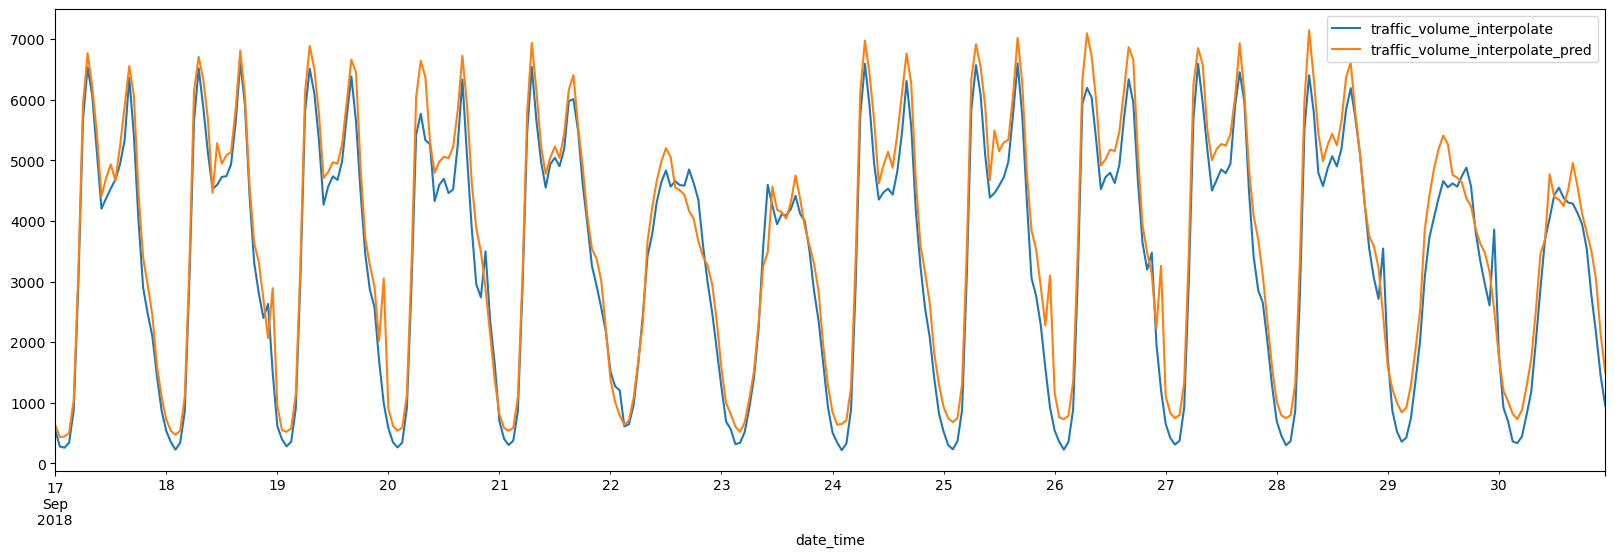

In [111]:
df_test_sarima.set_index('date_time').plot(y=['traffic_volume_interpolate', 'traffic_volume_interpolate_pred'], figsize=(20,6))

#### Вывод: "SARIMA is a disappoinment. So much effort and still in vain. " (SARIMA - это разочарование. Столько усилий и все равно напрасно)

In [112]:
#сравню все модели по MAPE
pd.DataFrame({'SARIMA': f'{mape_sarima:.2f}', 'Catboost': f'{mape_catb:.2f}', 'Base-line': f'{mape:.2f}'}, index=[1])

,SARIMA,Catboost,Base-line
1,0.27,0.08,0.09


## Выбираю Catboost. Прогноз трафика с доверительным интервалом

Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза.

<Axes: xlabel='date_time'>

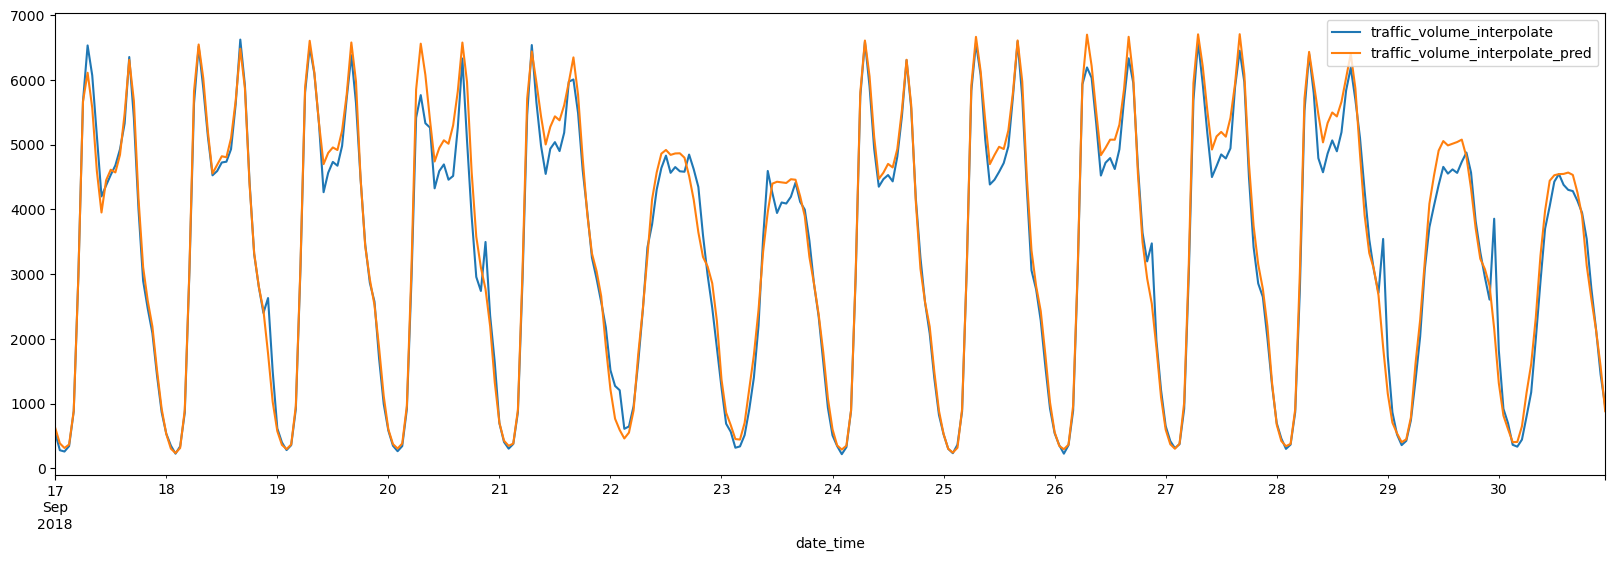

In [113]:
df_test.set_index('date_time').plot(y=['traffic_volume_interpolate', 'traffic_volume_interpolate_pred'], figsize=(20,6))

In [114]:
df_forecast = df_test.set_index('date_time')[['traffic_volume_interpolate', 'traffic_volume_interpolate_pred']].copy()

In [115]:
df_forecast['prediction_error'] = np.abs(df_forecast['traffic_volume_interpolate'] - df_forecast['traffic_volume_interpolate_pred'])
df_forecast['traffic_volume_interpolate_pred_upper'] = df_forecast['traffic_volume_interpolate_pred'] + df_forecast['prediction_error']
df_forecast['traffic_volume_interpolate_pred_lower'] = df_forecast['traffic_volume_interpolate_pred'] - df_forecast['prediction_error']

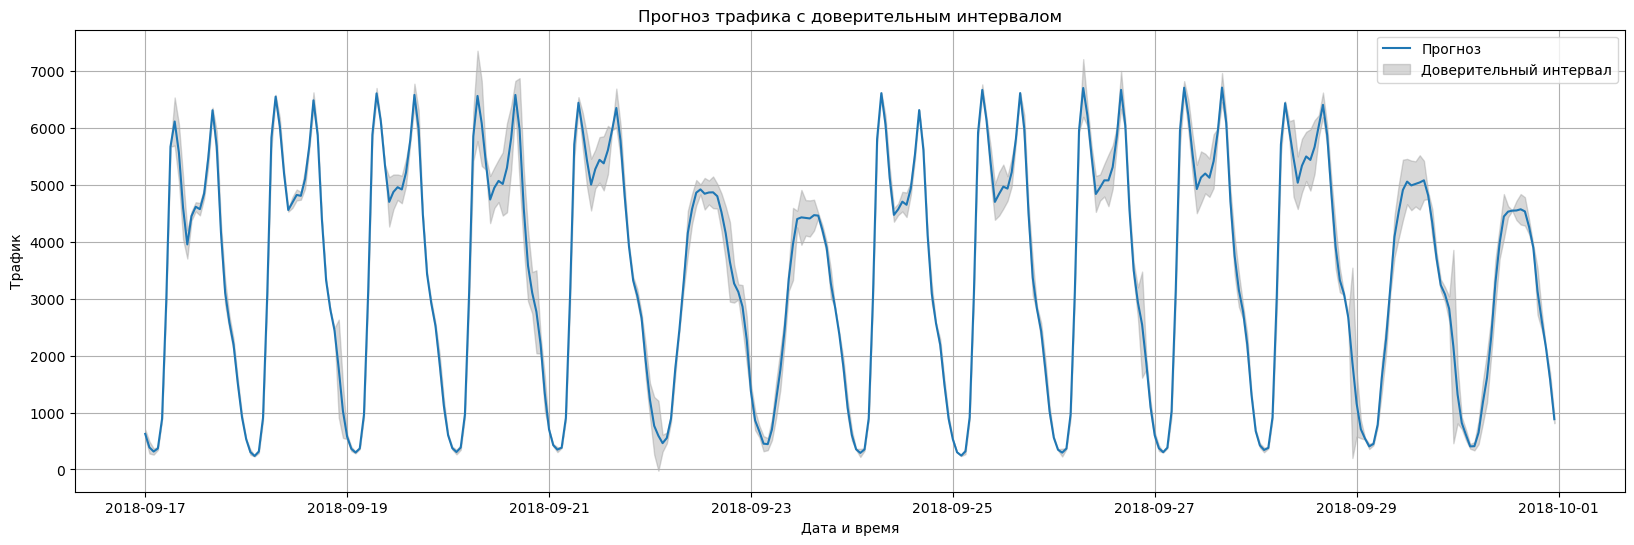

In [116]:
plt.figure(figsize=(20, 6))
plt.plot(df_forecast.index, df_forecast['traffic_volume_interpolate_pred'], label='Прогноз')
plt.fill_between(df_forecast.index, 
                 df_forecast['traffic_volume_interpolate_pred_upper'], 
                 df_forecast['traffic_volume_interpolate_pred_lower'], 
                 color='grey', alpha=0.3, label='Доверительный интервал')
plt.xlabel('Дата и время')
plt.ylabel('Трафик')
plt.title('Прогноз трафика с доверительным интервалом')
plt.legend()
plt.grid()
plt.show()

# Вывод:
 - Проведен EDA. Обнаружено: дубли, нарушена частота, есть подозрительные значения. Исправлено
 - Построены три модели: base-line как среднее предыдущих значений, catboost_regressor, SARIMA. SARIMA для 336 последних значений с помощью from pmdarima import auto_arima
 - ошибка MAPE: MAPE_base-line = 9%, MAPE_catboost = 8%, MAPE_SARIMA = 27%
 - для catboost построен график "Прогноз трафика с доверительным интервалом"